In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [2]:
FILEPATH = r'C:\Users\shanm\Downloads\archive3'
BATCH_SIZE = 128 
IMAGE_SIZE = (224, 224) 


ROUND_1_TRAINABLE_LAYERS = 0
ROUND_1_EPOCHS = 10

ROUND_2_TRAINABLE_LAYERS = 38
ROUND_2_LEARNING_SCALER = 0.2
ROUND_2_EPOCHS = 10

ROUND_3_TRAINABLE_LAYERS = 74
ROUND_3_LEARNING_SCALER = 0.2
ROUND_3_EPOCHS = 10

LEARNING_RATE = 0.001

MODEL_CHECKPOINT_FILEPATH = './Bird-Classifier-Model-Checkpoint.h5'

SEED = 6278 

In [3]:
train = image_dataset_from_directory(directory = FILEPATH + r'\train',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)



valid = image_dataset_from_directory(directory = FILEPATH + r'\valid',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)


test = image_dataset_from_directory(directory = FILEPATH + r'\test',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

Found 70626 files belonging to 450 classes.
Found 2250 files belonging to 450 classes.
Found 2250 files belonging to 450 classes.


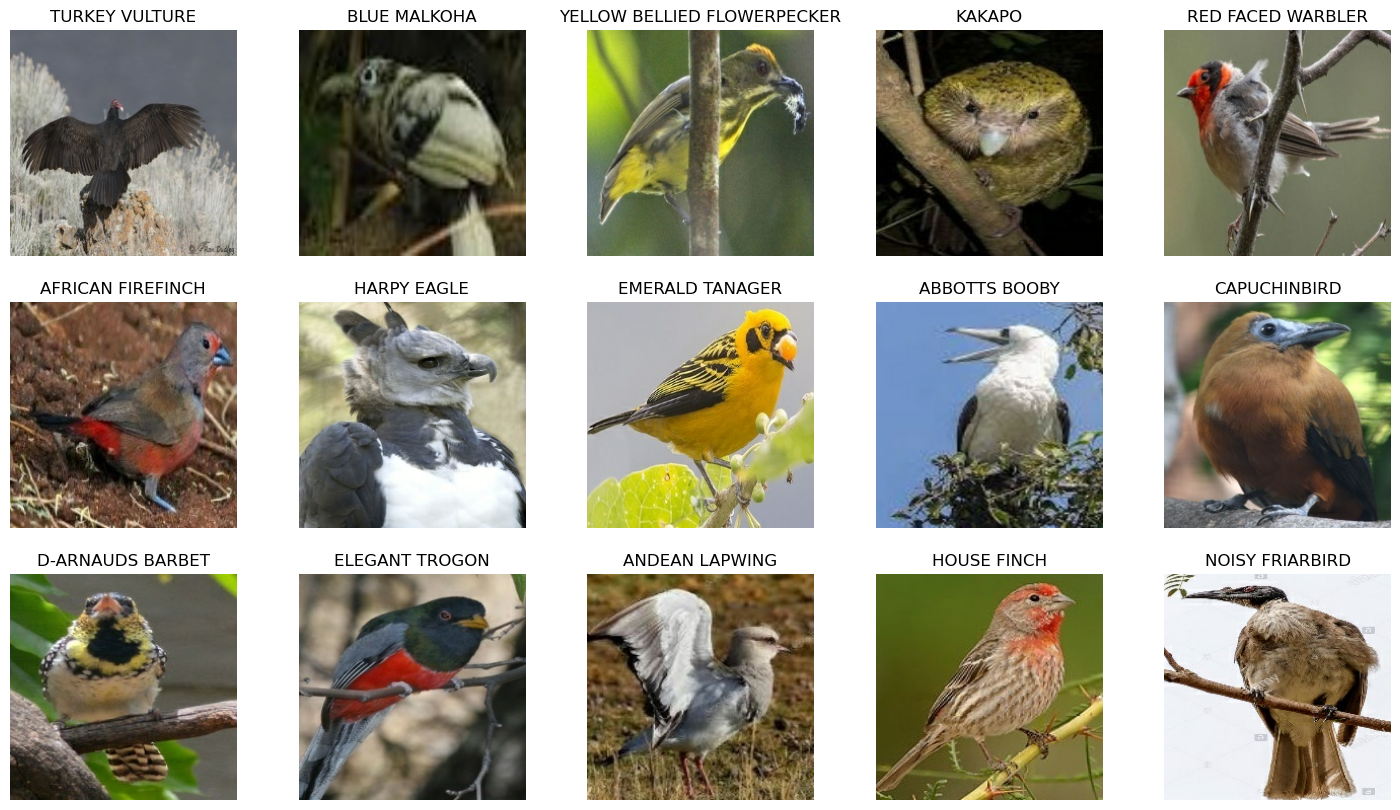

In [4]:
class_names = train.class_names

plt.figure(figsize=(18, 10))

for images, labels in train.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [5]:
def data_augmentor(h_flip=True, v_flip=False, rotate=True,):
    
    augmentor = Sequential() 
    augmentor.add(layers.Rescaling(1./255)) 

    
    if h_flip and v_flip:
        augmentor.add(layers.RandomFlip('horizontal_and_vertical'))
    elif h_flip:
        augmentor.add(layers.RandomFlip('horizontal'))
    elif v_flip:
        augmentor.add(layers.RandomFlip('vertical'))
   
    if rotate:
        augmentor.add(layers.RandomRotation(0.2))
    
    return augmentor

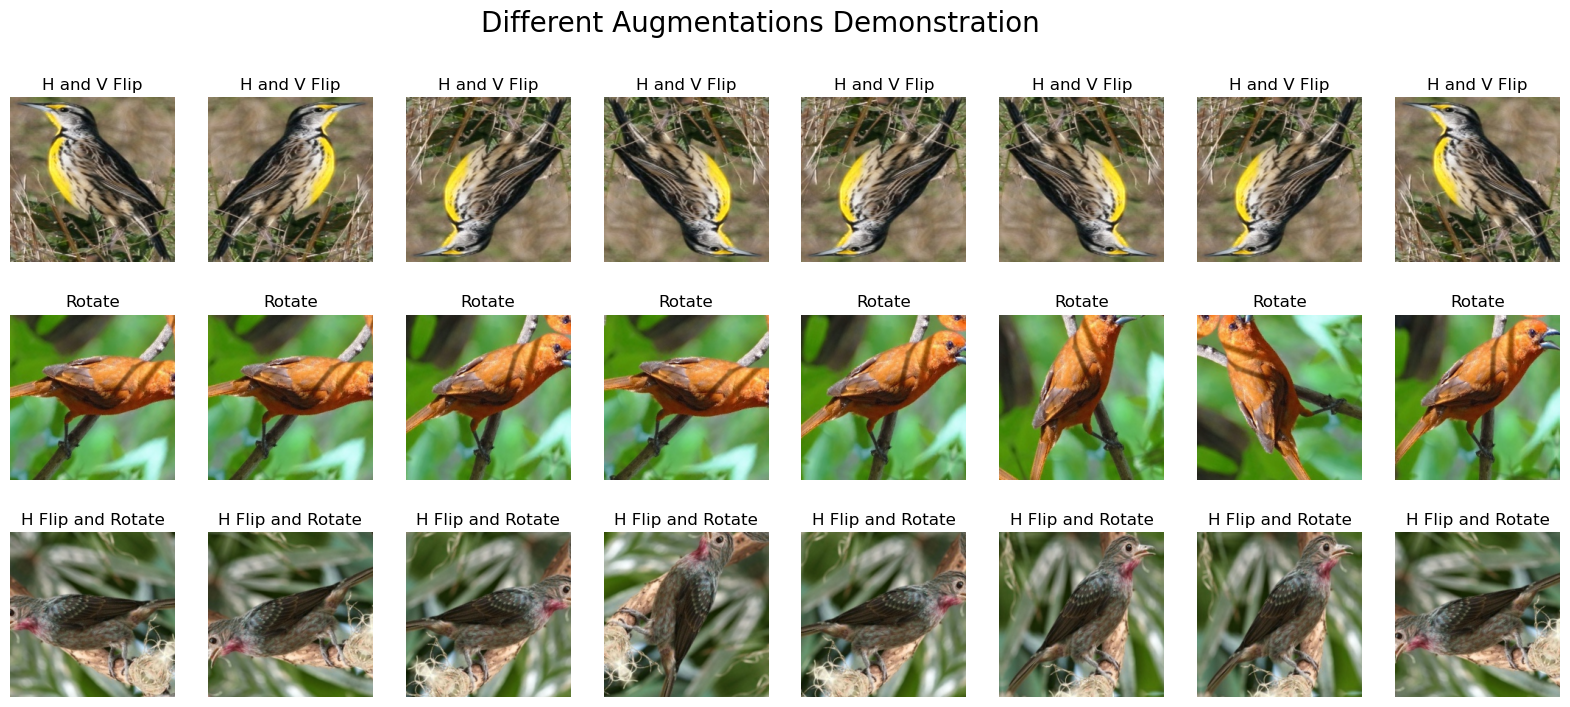

In [6]:
augmentor1 = data_augmentor(h_flip = True, v_flip = True, rotate=False)
augmentor2 = data_augmentor(h_flip = False, v_flip = False, rotate=True)
augmentor3 = data_augmentor(h_flip = True, v_flip = False, rotate=True)

augs = [augmentor1, augmentor2, augmentor3]

details = ['H and V Flip',
           'Rotate',
           'H Flip and Rotate']

plt.figure(figsize=(20, 8))
for images, labels in train.take(1):
    for i, aug in enumerate(augs):
        img = images[i]
        for j in range(8):
            ax = plt.subplot(3, 8, (i*8 + j + 1))
            img_augmented = aug(tf.expand_dims(img, 0))
            plt.imshow(img_augmented[0])
            plt.axis('off')
            ax.set_title(details[i])
            
plt.suptitle('Different Augmentations Demonstration', fontsize=20);

In [7]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

mobile_base = MobileNetV2(input_shape = IMAGE_SHAPE,
                          include_top = False,
                          weights = 'imagenet')

mn_layers = len(mobile_base.layers)

In [8]:
mobile_base.trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!\n'.format(ROUND_1_TRAINABLE_LAYERS))

for mn_layer in mobile_base.layers[:-ROUND_1_TRAINABLE_LAYERS]:
    mn_layer.trainable = False
    
trainableParams = np.sum([np.prod(v.get_shape()) for v in mobile_base.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in mobile_base.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams

print('The number of trainable parameters in the Mobile Net V2 Base Model is {}.'.format(trainableParams))
print('The number of non-trainable parameters in the Mobile Net V2 Base Model is {}.'.format(nonTrainableParams))
print('The total number of parameters is {}.'.format(totalParams))

Setting the last 0 layers in the Mobile Net Base Model to trainable!

The number of trainable parameters in the Mobile Net V2 Base Model is 2223872.
The number of non-trainable parameters in the Mobile Net V2 Base Model is 34112.
The total number of parameters is 2257984.


In [9]:
inputs = tf.keras.Input(shape = IMAGE_SHAPE)
x = augmentor3(inputs)
x = mobile_base(x)
x = layers.GlobalAveragePooling2D()(x) 
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(1500)(x) 
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(1200)(x) 
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(900)(x) 
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(450, activation='softmax')(x) 
        
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                             

In [10]:
optimizer_1 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

callbacks = [model_checkpoint]

model.compile(optimizer = optimizer_1,
              loss = loss,
              metrics=['accuracy'])

In [11]:
history = model.fit(train, 
                    validation_data=valid, 
                    epochs=ROUND_1_EPOCHS, 
                    callbacks = callbacks)

Epoch 1/10
552/552 [==============================] - ETA: 0s - loss: 2.5716 - accuracy: 0.4333 
Epoch 1: val_accuracy improved from -inf to 0.00756, saving model to .\Bird-Classifier-Model-Checkpoint.h5
552/552 [==============================] - 6574s 12s/step - loss: 2.5716 - accuracy: 0.4333 - val_loss: 14.3500 - val_accuracy: 0.0076
Epoch 2/10
552/552 [==============================] - ETA: 0s - loss: 1.0309 - accuracy: 0.7254 
Epoch 2: val_accuracy improved from 0.00756 to 0.05333, saving model to .\Bird-Classifier-Model-Checkpoint.h5
552/552 [==============================] - 6667s 12s/step - loss: 1.0309 - accuracy: 0.7254 - val_loss: 9.8278 - val_accuracy: 0.0533
Epoch 3/10
552/552 [==============================] - ETA: 0s - loss: 0.7705 - accuracy: 0.7876 
Epoch 3: val_accuracy improved from 0.05333 to 0.07911, saving model to .\Bird-Classifier-Model-Checkpoint.h5
552/552 [==============================] - 7601s 14s/step - loss: 0.7705 - accuracy: 0.7876 - val_loss: 10.6100 -

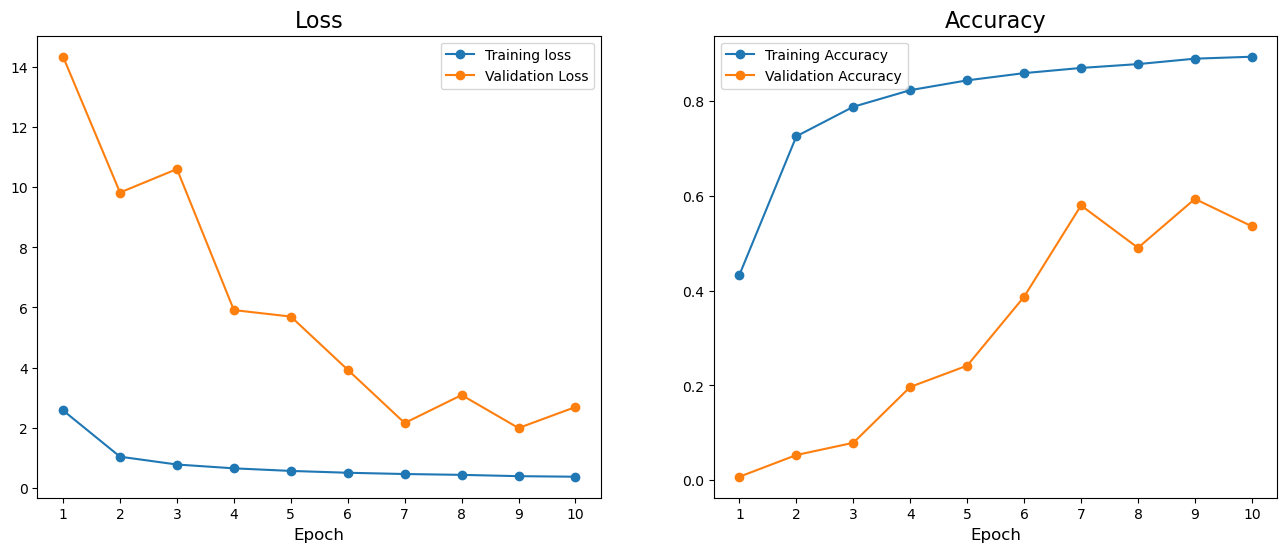

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs = ROUND_1_EPOCHS

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

In [13]:
model.layers[2].trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!'.format(ROUND_2_TRAINABLE_LAYERS))

for layer in model.layers[2].layers[:-ROUND_2_TRAINABLE_LAYERS]:
    layer.trainable = False

Setting the last 38 layers in the Mobile Net Base Model to trainable!


In [19]:
model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   verbose=1,
                                   mode = 'max')

In [20]:
optimizer_2 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE * ROUND_2_LEARNING_SCALER)

callbacks = [model_checkpoint, model.history]

model.compile(optimizer = optimizer_2,
              loss = loss,
              metrics=['accuracy'])

In [21]:
history = model.fit(train, 
                    validation_data=valid, 
                    epochs=ROUND_2_EPOCHS, 
                    callbacks = callbacks)

Epoch 1/10
552/552 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9272
Epoch 1: val_accuracy improved from -inf to 0.91156, saving model to .\Bird-Classifier-Model-Checkpoint.h5
552/552 [==============================] - 3052s 6s/step - loss: 0.2486 - accuracy: 0.9272 - val_loss: 0.3469 - val_accuracy: 0.9116
Epoch 2/10
552/552 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.9389
Epoch 2: val_accuracy improved from 0.91156 to 0.93644, saving model to .\Bird-Classifier-Model-Checkpoint.h5
552/552 [==============================] - 3405s 6s/step - loss: 0.2048 - accuracy: 0.9389 - val_loss: 0.2372 - val_accuracy: 0.9364
Epoch 3/10
552/552 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9453
Epoch 3: val_accuracy improved from 0.93644 to 0.94400, saving model to .\Bird-Classifier-Model-Checkpoint.h5
552/552 [==============================] - 4749s 9s/step - loss: 0.1816 - accuracy: 0.9453 - val_loss: 0.1935 - val_acc

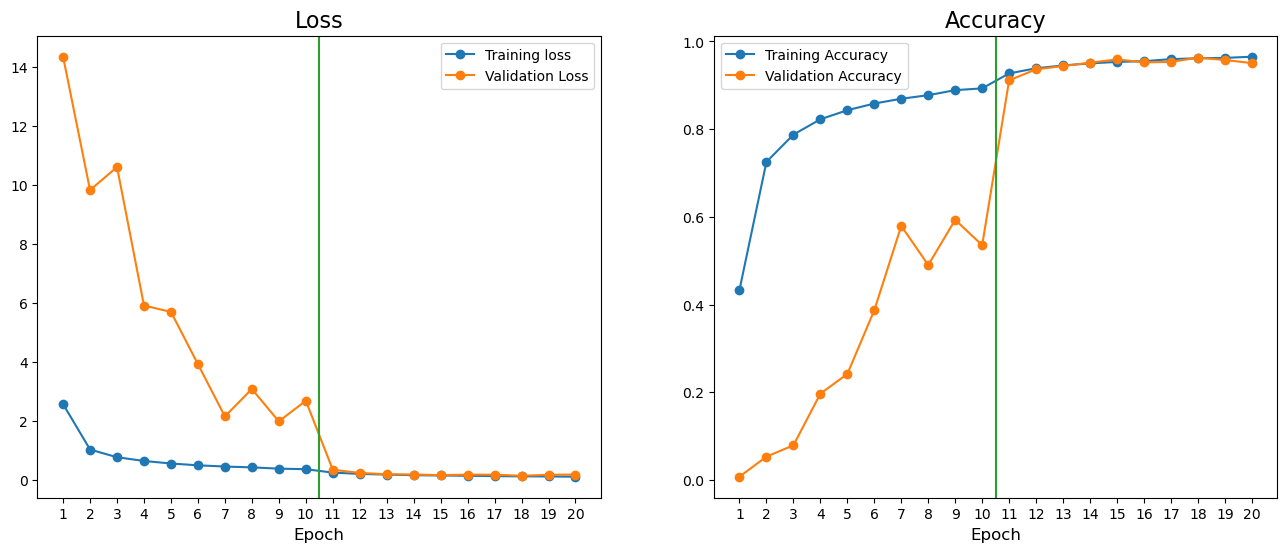

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs += ROUND_2_EPOCHS
new_rounds = [ROUND_1_EPOCHS + 0.5]

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize)

for new_round in new_rounds:
    ax1.axvline(new_round, c='tab:green')
    ax2.axvline(new_round, c='tab:green');

In [23]:
model.layers[2].trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!'.format(ROUND_3_TRAINABLE_LAYERS))

for layer in model.layers[2].layers[:-ROUND_3_TRAINABLE_LAYERS]:
    layer.trainable = False

Setting the last 74 layers in the Mobile Net Base Model to trainable!


In [24]:
optimizer_3 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE * ROUND_2_LEARNING_SCALER * ROUND_3_LEARNING_SCALER)

callbacks = [model_checkpoint, model.history]

model.compile(optimizer = optimizer_3,
              loss = loss,
              metrics=['accuracy'])

In [25]:
history = model.fit(train, 
                    validation_data=valid, 
                    epochs=ROUND_3_EPOCHS, 
                    callbacks = callbacks)

Epoch 1/10
552/552 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9697 
Epoch 1: val_accuracy improved from 0.96311 to 0.96356, saving model to .\Bird-Classifier-Model-Checkpoint.h5
552/552 [==============================] - 8429s 15s/step - loss: 0.0937 - accuracy: 0.9697 - val_loss: 0.1430 - val_accuracy: 0.9636
Epoch 2/10
552/552 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9743 
Epoch 2: val_accuracy improved from 0.96356 to 0.96622, saving model to .\Bird-Classifier-Model-Checkpoint.h5
552/552 [==============================] - 5857s 11s/step - loss: 0.0792 - accuracy: 0.9743 - val_loss: 0.1355 - val_accuracy: 0.9662
Epoch 3/10
552/552 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9767
Epoch 3: val_accuracy did not improve from 0.96622
552/552 [==============================] - 5080s 9s/step - loss: 0.0731 - accuracy: 0.9767 - val_loss: 0.1300 - val_accuracy: 0.9653
Epoch 4/10
552/552 [==================

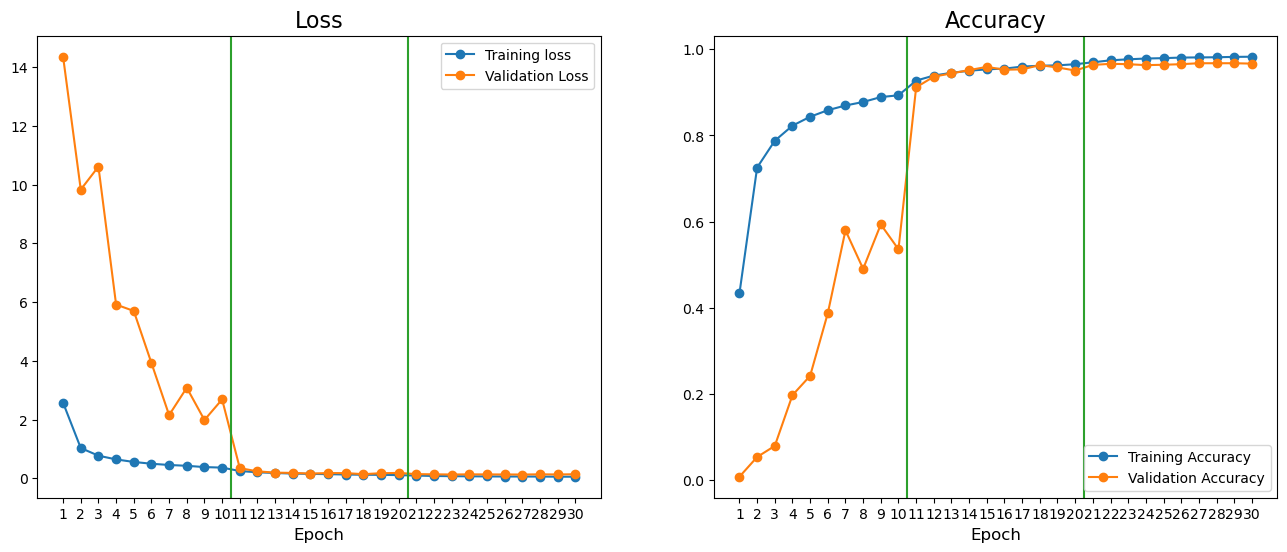

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs += ROUND_3_EPOCHS
new_rounds += [ROUND_1_EPOCHS + ROUND_2_EPOCHS + 0.5]

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

for new_round in new_rounds:
    ax1.axvline(new_round, c='tab:green')
    ax2.axvline(new_round, c='tab:green');

In [27]:
model.load_weights(MODEL_CHECKPOINT_FILEPATH)

test_loss, test_accuracy = model.evaluate(test)

print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

18/18 [==============================] - 63s 3s/step - loss: 0.0576 - accuracy: 0.9822

The model had an accuracy score of 98.2%!!


4/4 [==============================] - 5s 831ms/step


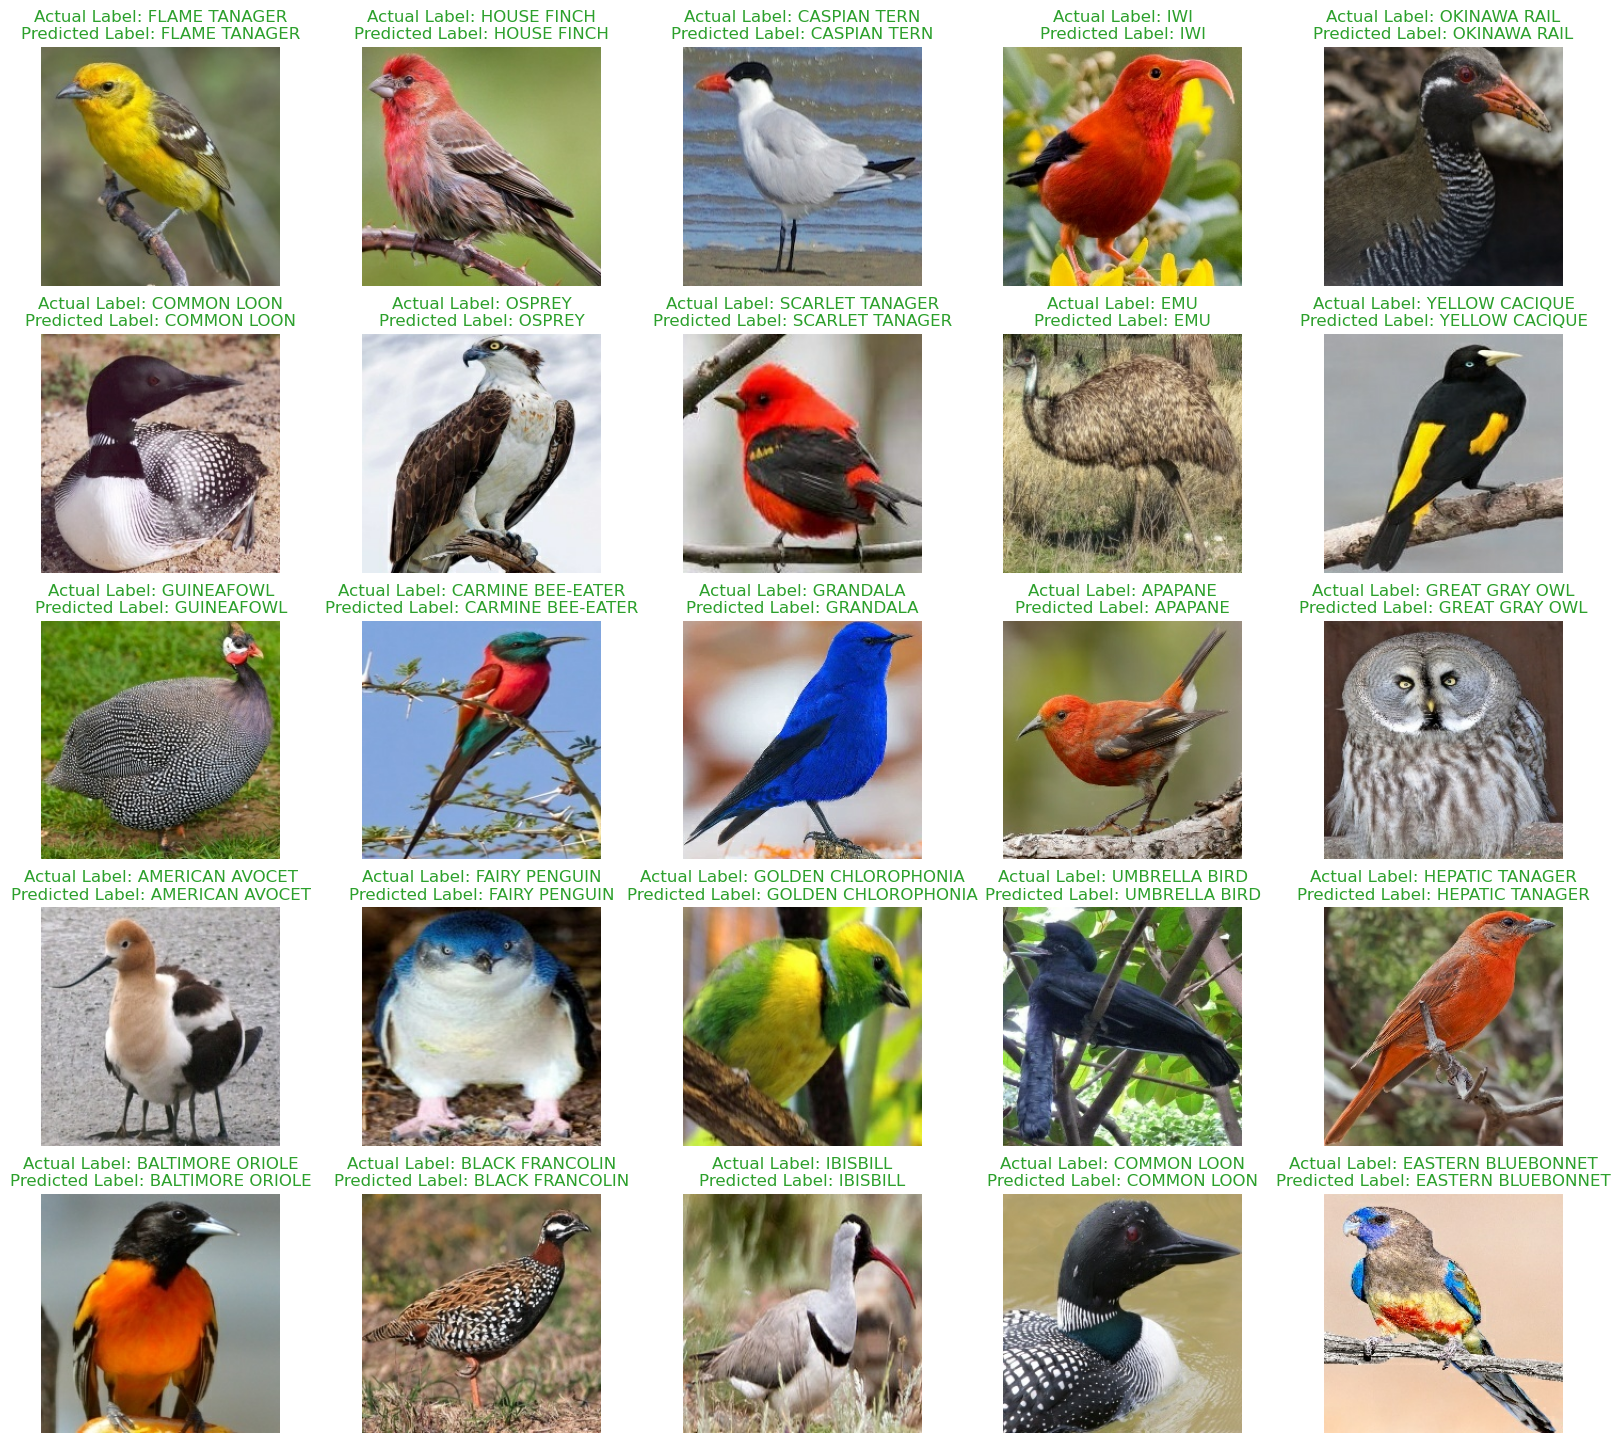

In [28]:
plt.figure(figsize=(20, 18))

for images, labels in test.take(1):
    guesses = np.argmax(model.predict(images), axis=1)
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if guesses[i] == np.argmax(labels[i]):
            color = 'tab:green'
        else:
            color = 'tab:red'
        plt.title('Actual Label: {}\nPredicted Label: {}'.format(
                            class_names[np.argmax(labels[i])], class_names[guesses[i]]),
                 color = color)
        plt.axis("off")

In [29]:
model.save('model.h5')

In [30]:
print(labels)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 450), dtype=float32)


In [31]:
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE BREASTED PITTA',
 'AZURE JAY',
 'AZURE TANAGER',
 'AZURE TIT',
 'BAIKAL TEAL',
 'BALD EAGLE',
 'BALD IBIS',
 'BALI